# Clustering by Representational Similarity

Previous work has applied a distance rank analysis to summarize with a single scalar value the tendency to group together nearby items using various distance metrics, including serial order and semantic similarity. This analysis is also probably applicable to measure the extent how recall is clustered according to latent representational states inferred with our models. For example, the distance_rank analysis can be applied to data using semantic similarities from GloVe, but also to semantic connections simulated with the Landscape model.

To really underline how dynamics within the Landscape model progressively _evolve_ a representation of semantic associations between items, we can simulate the study phase of each trial using the model's default parameters and track this distance_rank statistic at each increment. A horizontal line records the initial value based on pre-existing semantic associations, also the default matrix used for SemanticCMR and associated analyses.

## Load Relevant Dependencies and Data
For flexibility, we'll retrieve our own similarities.

In [1]:
from Landscape_Model import LandscapeRevised
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from psifr import fr
import spacy

# load recall data frame
data = pd.read_csv('data/psifr_sbs.csv')
events = fr.merge_free_recall(
    data, list_keys=['item_index', 'cycle', 'story_index', 
                     'story_name', 'time_test'])

# paraphrase-MiniLM-L12-v2
# average_word_embeddings_glove.6B.300d
# average_word_embeddings_glove.840B.300d
# stsb-distilbert-base
model = SentenceTransformer('average_word_embeddings_glove.840B.300d')
units = events.pivot_table(index=['story_name', 'input'], values='item', aggfunc='first').reset_index()
connections = {}
remove_stopwords = False
nlp = spacy.load('en_core_web_sm')

for story_name in ['Fisherman', 'Supermarket', 'Flight', 'Cat', 'Fog', 'Beach']:
    
    sentences = units.loc[units.story_name==story_name].item.values.tolist()
    
    clean_sentences = []
    for i in range(len(sentences)):
        if remove_stopwords:
            text_token = nlp(sentences[i])
            clean_sentences.append(' '.join([word.text for word in text_token if not word.is_stop]))
        else:
            clean_sentences.append(sentences[i])
    
    #Compute embeddings
    embeddings = model.encode(clean_sentences, convert_to_tensor=True)

    #Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = np.abs(util.pytorch_cos_sim(embeddings, embeddings).numpy())
    cosine_scores[np.eye(len(cosine_scores), dtype='bool')] = np.nan
    connections[story_name] = cosine_scores

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,item_index,cycle,story_index,story_name,time_test
0,0,0,One fine day an old Maine man was fishing,1.0,NaN,True,False,0,False,0,0,0,Fisherman,1
1,0,0,on his favorite lake,2.0,2.0,True,True,0,False,1,0,0,Fisherman,1
2,0,0,and catching very little,3.0,NaN,True,False,0,False,2,0,0,Fisherman,1
3,0,0,"Finally, he gave up",4.0,3.0,True,True,0,False,3,1,0,Fisherman,1
4,0,0,and walked back along the shore to his fishing...,5.0,NaN,True,False,0,False,4,1,0,Fisherman,1


## Demo Representational Clustering Analysis for Initial Model State
For each story and time_test, initialize the model with the relevant connectivity matrix, perform the lag_rank analysis over the dataset using the matrix, combine dataFrames, and plot the result.

In [2]:

distance_ranks = []

# build list of distance_rank dfs across each factor i'm interested
for time_test in pd.unique(events.time_test):
    for story_name in pd.unique(events.story_name):

        # initialize the model with the relevant connectivity matrix
        model = LandscapeRevised(connections[story_name])
        model.connections[np.eye(model.unit_count, dtype='bool')] = 0

        # perform the distance_rank analysis over the dataset using the matrix
        distance_rank = fr.distance_rank(
            events.loc[(events.story_name==story_name) & (events.time_test==time_test)], 
            'item_index', 1-model.connections).reset_index()

        distance_rank['story_name'] = story_name
        distance_rank['time_test'] = time_test
        distance_ranks.append(distance_rank)
        
distance_rank = pd.concat(distance_ranks)
distance_rank = distance_rank.loc[distance_rank.time_test != 1]
distance_rank = distance_rank.pivot_table(index=['time_test', 'subject'], values='rank').reset_index()
distance_rank.head()

C:\ProgramData\Miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
C:\ProgramData\Miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
C:\ProgramData\Miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
C:\ProgramData\Miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
C:\ProgramData\Miniconda3\lib\site-packages\psifr\measures.py:298: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,time_test,subject,rank
0,2,0,0.529201
1,2,1,0.507384
2,2,2,0.531900
3,2,3,0.544004
4,2,4,0.503780


**Note**: Some of these rank values are nan for a given subject and condition. This is because participants didn't recall anything during these particular trials. This doesn't seem to affect downstream analyses. We'll demonstrate as much with our successive analysis: a dotplot of semantic organization scores factored by time_test and subject.

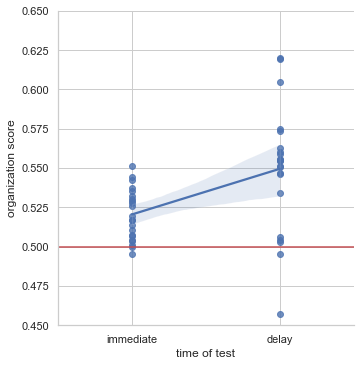

In [3]:

sns.set(style='whitegrid')
sns.lmplot(data=distance_rank, 
    x="time_test", y="rank", palette="deep");
plt.xticks([2, 3], ['immediate', 'delay'])
plt.axhline(y=.5, color='r', label='chance')
plt.xlim([1.5, 3.5])
plt.ylim([.45, .65])
plt.xlabel('time of test')
plt.ylabel('organization score');

## Simulation Configuration
Let's demonstrate how to efficiently simulate the Landscape Model using the stimuli from our SBS dataset.

DataFrame construction should look much like the above, except with an extra factor varied over: `simulation_step`. From there, I'll apply another `pivot_table`, this time generalizing over subjects (or perhaps letting seaborn do that for me with its confidence interval support). The objective is a lineplot relating `simulation_step` with mean organization score across subjects.

But what about simulation configuration? The key thing to work through is how to operate the `cycles` argument of `LandscapeRevised.experience`. The important thing is that each entry of `cycles` selects the right entries of `self.activations` to update when I assign `self.max_activity` within `LandscapeRevised.update_activations`. This probably just requires a list of indices per entry, right? Do I already have code for that?

### Cycle Extraction
Let's just directly get a list of cycles containing indices of relevant units.

In [4]:
experiences = {}

cycle_table = events.pivot_table(index=['story_name'], columns='input', values='cycle')

for story_name in connections.keys():
    v = cycle_table.loc[story_name].values
    
    next_experience = []
    current_cycle = 0
    experiences[story_name] = []

    for unit_index, cycle_index in enumerate(v):
        if current_cycle != cycle_index:
            experiences[story_name].append(next_experience)
            next_experience = [unit_index]
            current_cycle = cycle_index
        else:
            next_experience.append(unit_index)

print(experiences['Fisherman'])

[[0, 1, 2], [3, 4], [5], [6], [7], [8], [9, 10], [11], [12, 13], [14, 15], [16, 17], [18], [19], [20], [21], [22], [23], [24], [25, 26], [27], [28, 29], [30], [31], [32], [33], [34], [35], [36], [37, 38], [39], [40], [41]]


In [5]:
distance_ranks = []

# build list of distance_rank dfs across each factor i'm interested
for time_test in pd.unique(events.time_test):
    for story_name in pd.unique(events.story_name):

        # initialize model and store initial distance_rank df
        model = LandscapeRevised(connections[story_name])
        model.connections[np.eye(model.unit_count, dtype='bool')] = 0

        # perform the distance_rank analysis over the dataset using the matrix
        distance_rank = fr.distance_rank(
            events.loc[(events.story_name==story_name) & (events.time_test==time_test)], 
            'item_index', 1-model.connections).reset_index()

        # factor-specific information
        distance_rank['story_name'] = story_name
        distance_rank['time_test'] = time_test
        distance_rank['simulation_step'] = 0
        distance_ranks.append(distance_rank)

        # add a further inner loop over cycles in story_name
        for cycle in experiences[story_name]:
            model.experience([cycle])

            # perform the distance_rank analysis over the dataset using the matrix
            distance_rank = fr.distance_rank(
                events.loc[(events.story_name==story_name) & (events.time_test==time_test)], 
                'item_index', 1-model.connections).reset_index()

            # factor-specific information
            distance_rank['story_name'] = story_name
            distance_rank['time_test'] = time_test
            distance_rank['simulation_step'] = 0
            distance_ranks.append(distance_rank)

distance_rank = pd.concat(distance_ranks)
distance_rank = distance_rank.loc[distance_rank.time_test != 1]
distance_rank.head()

ValueError: operands could not be broadcast together with shapes (41,41) (1681,1681) (41,41) 